<h1><center>Прогнозирование оттока клиента Банка</center></h1>

На основе исторических данных о поведении клиентов и расторжении договоров с банком требуется спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.  

Источник данных: [kaggle.com](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Цель работы** – постройте модель с предельно большим значением *F1*-меры. Нижняя граница *F1* = 0.59. Дополнительно следует измерить *AUC-ROC*.

**Ход работы**  
1. [Загрузка](#Загрузка)
2. [Предобработка данных](#Предобработка-данных)
3. [Исследовательский анализ данных](#Исследовательский-анализ-данных)
4. [Тестирование моделей без учёта дисбаланса](#Тестирование-моделей-без-учёта-дисбаланса)
5. [Итоговое тестрование](#Итоговое-тестирование)
6. [Общий вывод](#Общий-вывод)

## Загрузка

**Загрузка необходимых модулей**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.combine import SMOTETomek
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

**Загрузка данных**

In [2]:
# try:
#     df = pd.read_csv('C:\\Users\\Jemiah\\Documents\\Jupyter_Data\\Churn_Modelling.csv')
# except:
#     df = pd.read_csv('/datasets/Churn.csv')

df = pd.read_csv(r'C:\Users\dcba5\Python_Jupyter_files\Data\Churn_Modelling.csv')

## Предобработка данных

In [3]:
# приводим названия столбцов к snake_case для удобства
# изменяем некоторые названия

df.columns = df.columns.str.lower()
df = df.rename(columns={'rownumber': 'row', 
                        'customerid': 'id', 
                        'creditscore': 'score', 
                        'numofproducts': 'prod_num', 
                        'hascrcard': 'card', 
                        'isactivemember': 'is_active', 
                        'estimatedsalary': 'salary'
                       })

In [4]:
# столбец row дублирует индекс, поэтому удаляем его

df.drop('row', axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         10000 non-null  int64  
 1   surname    10000 non-null  object 
 2   score      10000 non-null  int64  
 3   geography  10000 non-null  object 
 4   gender     10000 non-null  object 
 5   age        10000 non-null  int64  
 6   tenure     10000 non-null  int64  
 7   balance    10000 non-null  float64
 8   prod_num   10000 non-null  int64  
 9   card       10000 non-null  int64  
 10  is_active  10000 non-null  int64  
 11  salary     10000 non-null  float64
 12  exited     10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


In [6]:
# выявление явных дубликатов

df.duplicated().sum()

0

In [7]:
# изменение типов данных

df.balance = df.balance.astype(np.int64)
df.salary = df.salary.astype(np.int64)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         10000 non-null  int64 
 1   surname    10000 non-null  object
 2   score      10000 non-null  int64 
 3   geography  10000 non-null  object
 4   gender     10000 non-null  object
 5   age        10000 non-null  int64 
 6   tenure     10000 non-null  int64 
 7   balance    10000 non-null  int64 
 8   prod_num   10000 non-null  int64 
 9   card       10000 non-null  int64 
 10  is_active  10000 non-null  int64 
 11  salary     10000 non-null  int64 
 12  exited     10000 non-null  int64 
dtypes: int64(10), object(3)
memory usage: 1015.8+ KB


В ходе первого этапа работы были загружены необходимые модули и произведена первичная оценка данных. Пропусков не обнаружено. Названия заменены на более удобные и приведены к snake_case. Явных дубликатов не обнаружено. Типы столбцов содержащих числа с плавающей точкой были заменены на целочисленные.

## Исследовательский анализ данных

**Изучение целевого признака**

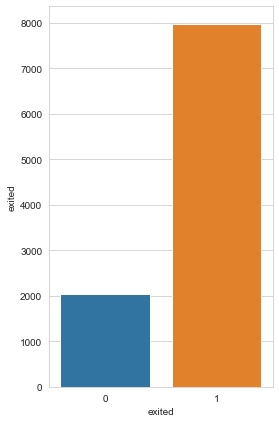

In [9]:
# стиль графиков
sns.set_style('whitegrid')

# визуализация целевого признака
fig = plt.figure(figsize=(4, 7))
sns.barplot(x=df.exited, y=df.exited.value_counts())
plt.show()

Выявлен дисбаланс классов в соотношении 4:1
Изучим работу моделей "решающее дерево", "случайный лес" и "логистическая регрессия" на датасете без учёта дисбаланса классов.

**Изучение признаков для обучения**

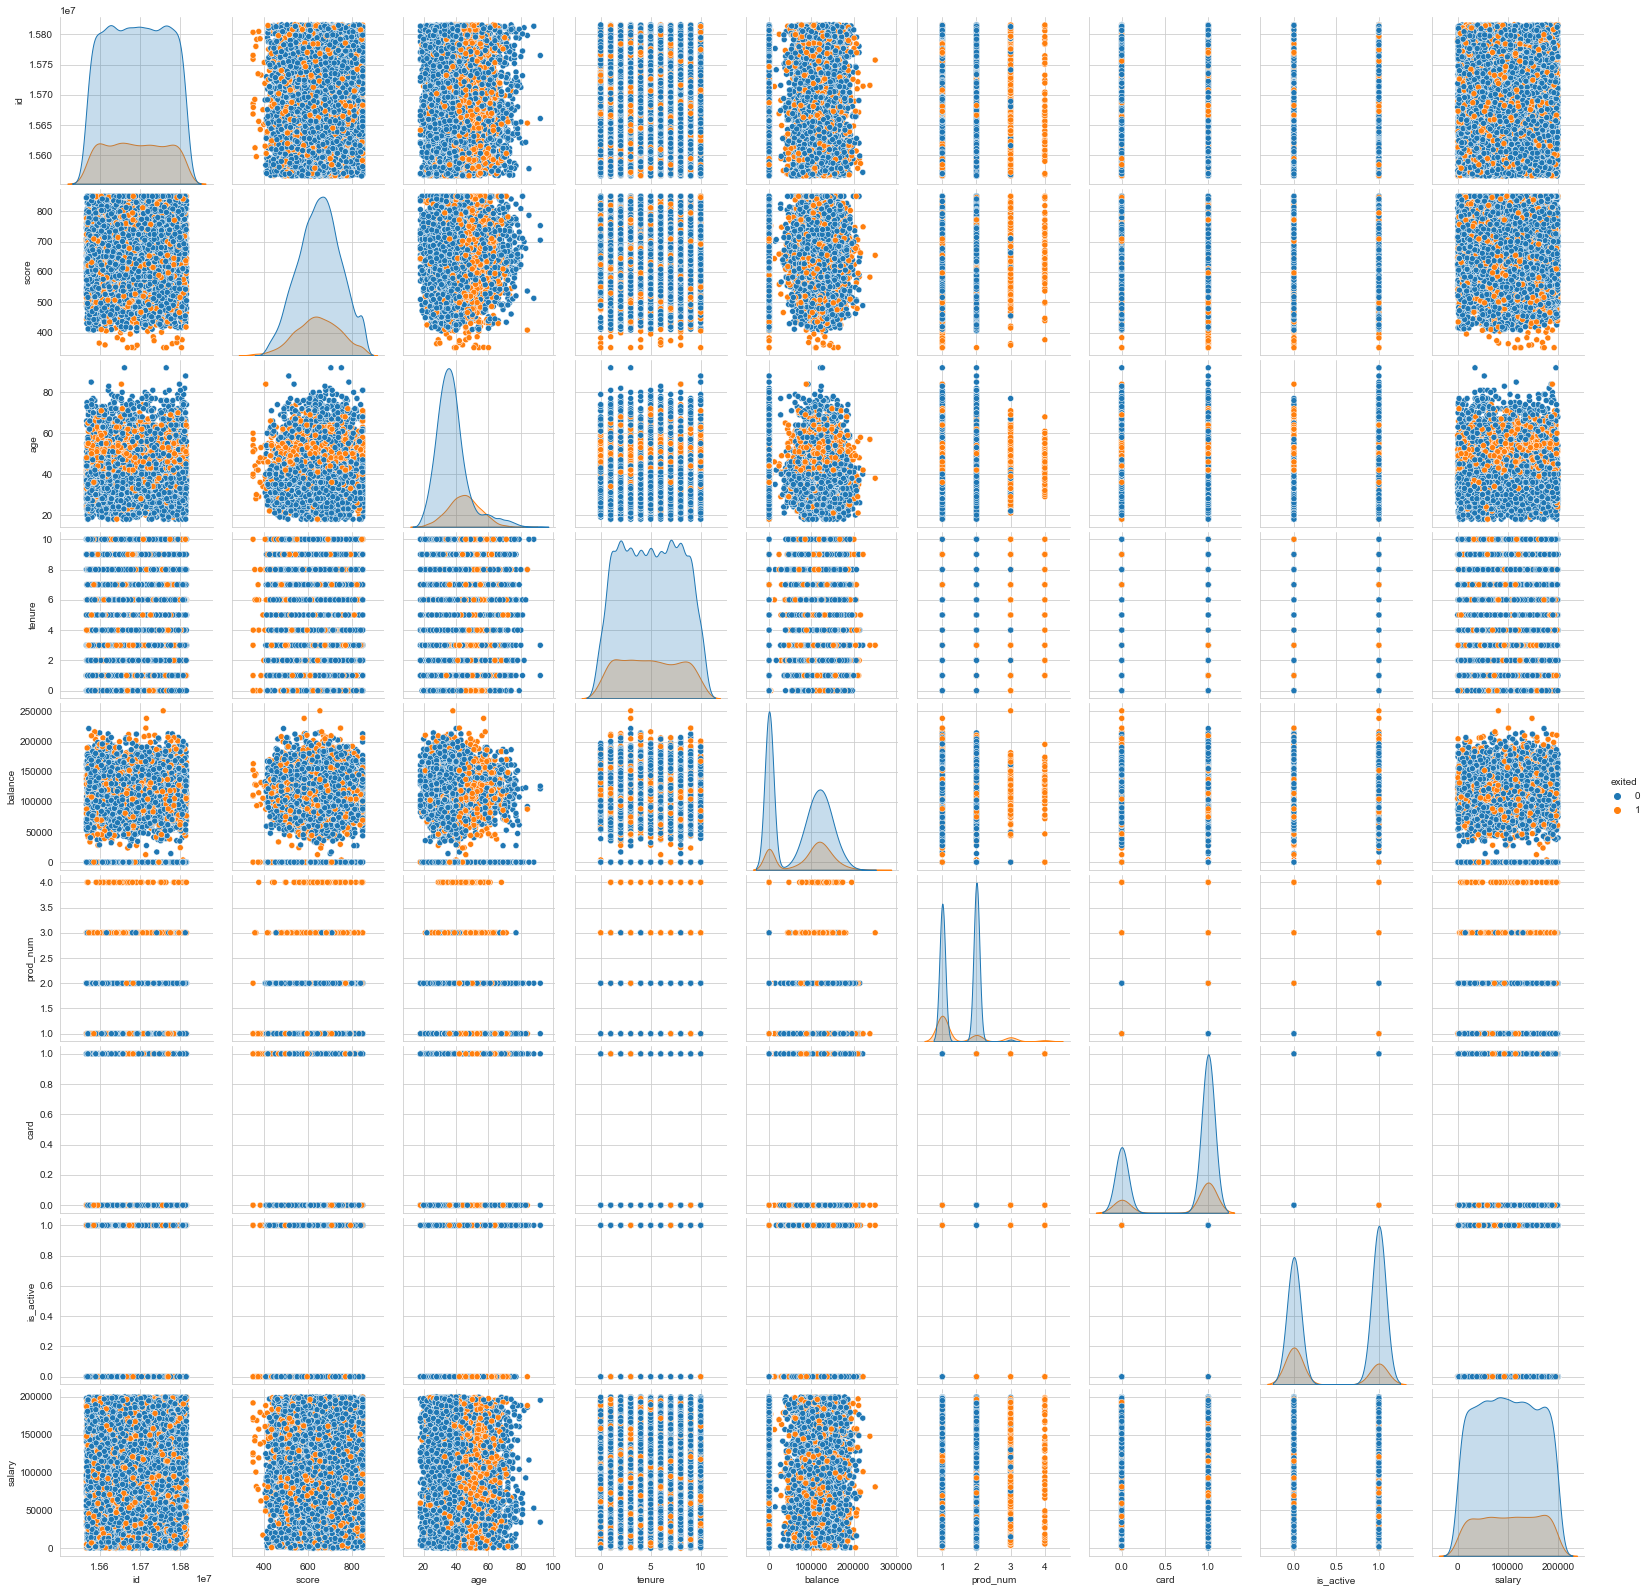

In [10]:
# оценка распределения количественных признаков и корреляции

sns.pairplot(df, hue='exited')
plt.show()

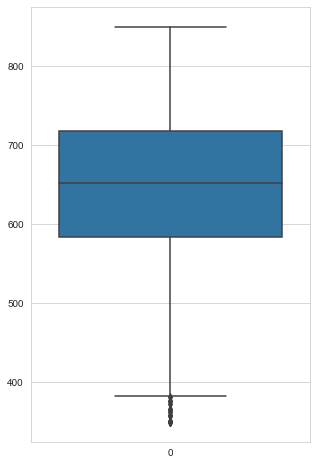

Кол-во выбросов: 0.14 %


In [11]:
plt.figure(figsize=(5, 8))
sns.boxplot(data=df.score)
plt.show()

print('Кол-во выбросов:', len(df.query('score < 380')) * 100 / len(df), '%')

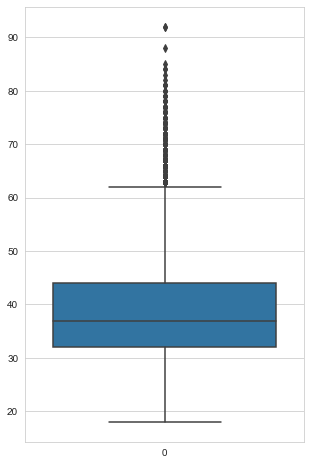

Кол-во выбросов: 3.59 %


In [12]:
plt.figure(figsize=(5, 8))
sns.boxplot(data=df.age)
plt.show()

print('Кол-во выбросов:', len(df.query('age > 62')) * 100 / len(df), '%')

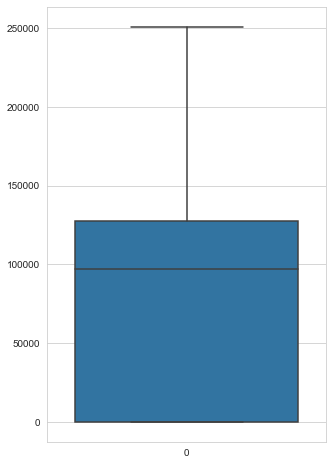

In [13]:
plt.figure(figsize=(5, 8))
sns.boxplot(data=df.balance)
plt.show()

Столбцы surname и id не влияют на целевой признак по определению и должны быть удалены.

In [14]:
df.drop(['id', 'surname'], axis=1, inplace=True)

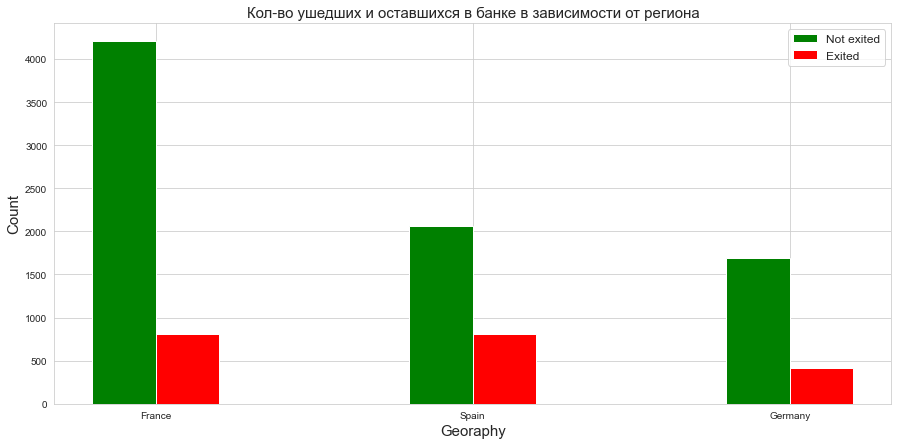

In [15]:
geo_0 = df[df.exited == 0].geography
geo_1 = df[df.exited == 1].geography

plt.figure(figsize=(15, 7))

w = 0.2
indent = 0.1
ticks = np.arange(len(geo_0.unique()))

plt.bar(ticks-indent, geo_0.value_counts(), width=w, color='g')
plt.bar(ticks+indent, geo_1.value_counts(), width=w, color='r')
plt.title('Кол-во ушедших и оставшихся в банке в зависимости от региона', fontsize=15)
plt.xlabel('Georaphy', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(ticks, df.geography.unique())
plt.legend(['Not exited', 'Exited'], fontsize=12)
plt.show()

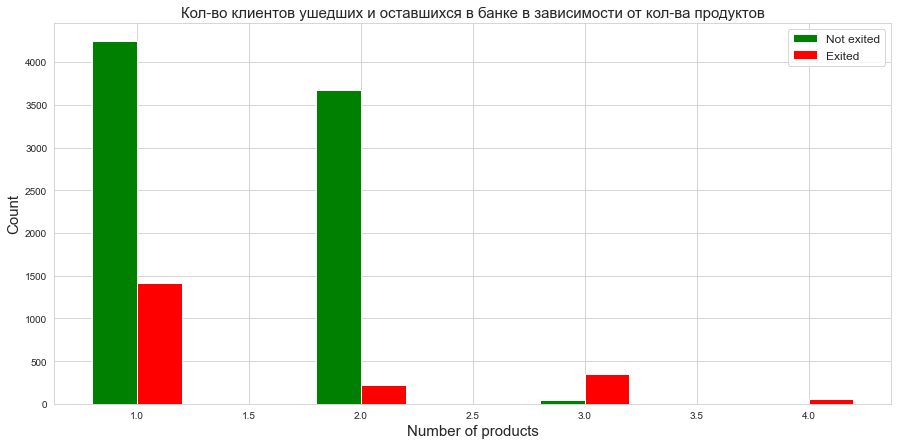

In [16]:
pn_0 = df[df.exited == 0].prod_num
pn_1 = df[df.exited == 1].prod_num

plt.figure(figsize=(15, 7))

w = 0.2
indent = 0.1

plt.bar(pn_0.unique()-indent, pn_0.value_counts(), width=w, color='g')
plt.bar(pn_1.unique()+indent, pn_1.value_counts(), width=w, color='r')
plt.title('Кол-во клиентов ушедших и оставшихся в банке в зависимости от кол-ва продуктов', fontsize=15)
plt.xlabel('Number of products', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(['Not exited', 'Exited'], fontsize=12)
plt.show()

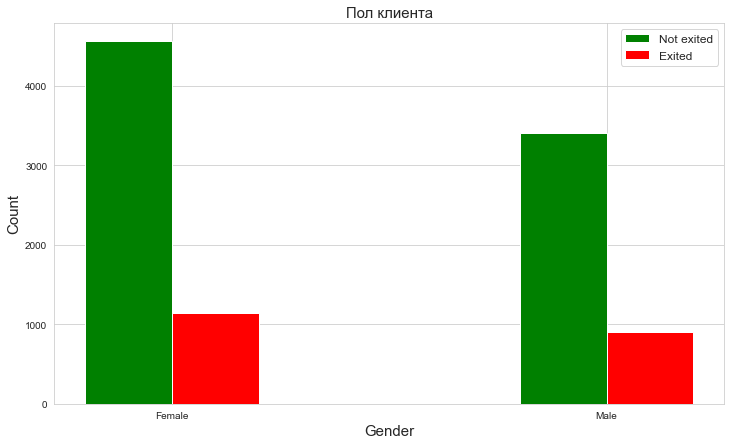

In [17]:
gender_0 = df[df.exited == 0].gender
gender_1 = df[df.exited == 1].gender

plt.figure(figsize=(12, 7))

w = 0.2
indent = 0.1
ticks = np.arange(len(gender_0.unique()))

plt.bar(ticks-indent, gender_0.value_counts(), width=w, color='g')
plt.bar(ticks+indent, gender_1.value_counts(), width=w, color='r')
plt.title('Пол клиента', fontsize=15)
plt.xlabel('Gender', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(ticks, df.gender.unique())
plt.legend(['Not exited', 'Exited'], fontsize=12)
plt.show()

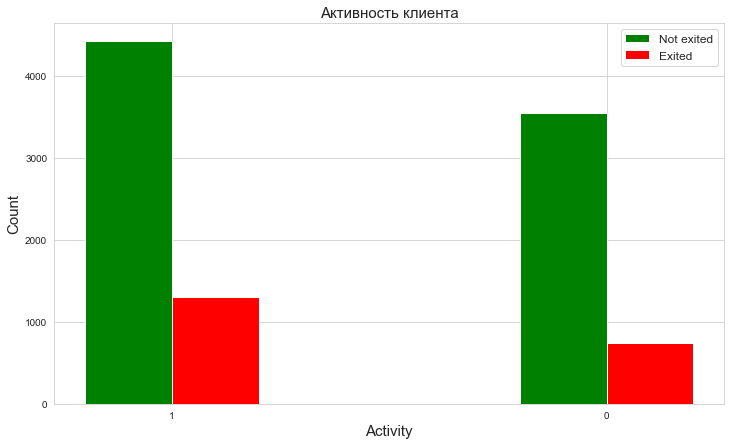

In [18]:
act_0 = df[df.exited == 0].is_active
act_1 = df[df.exited == 1].is_active

plt.figure(figsize=(12, 7))

w = 0.2
indent = 0.1
ticks = np.arange(len(act_0.unique()))

plt.bar(ticks-indent, act_0.value_counts(), width=w, color='g')
plt.bar(ticks+indent, act_1.value_counts(), width=w, color='r')
plt.title('Активность клиента', fontsize=15)
plt.xlabel('Activity', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(ticks, df.is_active.unique())
plt.legend(['Not exited', 'Exited'], fontsize=12)
plt.show()

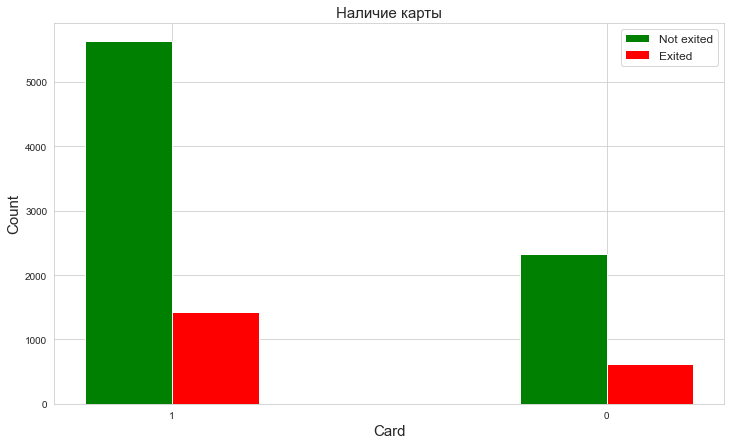

In [19]:
card_0 = df[df.exited == 0].card
card_1 = df[df.exited == 1].card

plt.figure(figsize=(12, 7))

w = 0.2
indent = 0.1
ticks = np.arange(len(act_0.unique()))

plt.bar(ticks-indent, card_0.value_counts(), width=w, color='g')
plt.bar(ticks+indent, card_1.value_counts(), width=w, color='r')
plt.title('Наличие карты', fontsize=15)
plt.xlabel('Card', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(ticks, df.card.unique())
plt.legend(['Not exited', 'Exited'], fontsize=12)
plt.show()

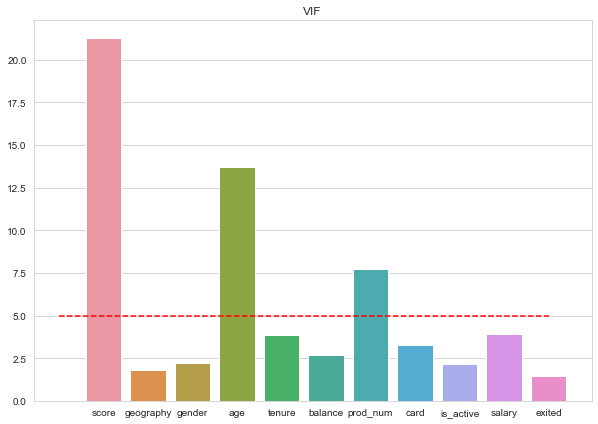

In [20]:
# коэффициент инфляции дисперсии
# позволяет установить какие признаки рекомендуется исключить 
# в случае использования линейной модели
# vif > 5 => признак легко выражается через другие

# порядковый кодировщик

columns_to_encoding = ['geography', 'gender']

ord = OrdinalEncoder()
ord.fit(df[columns_to_encoding])

# создаём датафрейм для работы variance_inflation_factor
vif_features = df
vif_features[columns_to_encoding] = ord.transform(df[columns_to_encoding])
vif = [variance_inflation_factor(vif_features, i) for i in range(len(vif_features.columns))]

# график и линия отсечения признаков
plt.figure(figsize=(10,7))
sns.barplot(x=vif_features.columns.to_list(),
            y=vif)
plt.title('VIF')
plt.plot([-1, 10], [5, 5], linestyle='--', color='r')
plt.show()

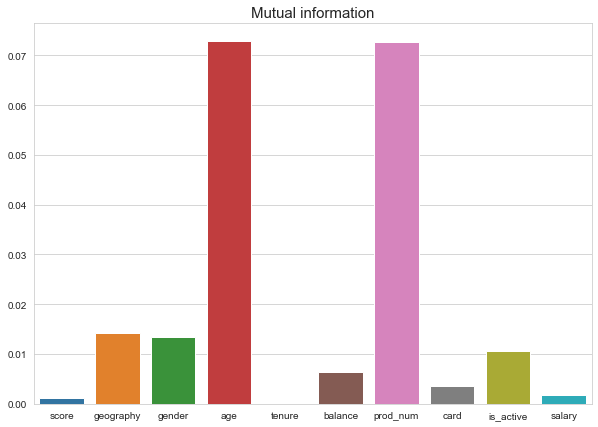

In [21]:
# отбор признаков методом mutual infromation

x = df.drop('exited', axis=1)
y = df.exited

mi = mutual_info_classif(x, y)
plt.figure(figsize=(10, 7))
plt.title('Mutual information', fontsize=15)
sns.barplot(x=x.columns, y=mi)
plt.show()

В ходе этапа было обнаружено около 4% выбросов. Признаки salary и tenure распределены равномерно. Метод mutual information так же показывает низкий уровень влияния признаков tenure и salary, следовательно от них можно избавиться. Однако MI так же показывает отсутствие влияния признака score. Пока его трогать не будем и посмотрим как модели будут себя вести.

**Формирование выборок**

In [22]:
# признаки 
features = df.drop(['exited', 'tenure', 'salary'], axis=1)

# целевой признак
target = df.exited

In [23]:
# подготовка к кодированию
features = features.drop(columns_to_encoding, axis=1)

In [24]:
# настройка кодировщика

ohe = OneHotEncoder(drop='first', sparse=False)
ohe.fit(df[columns_to_encoding])

features_ohe = pd.DataFrame(ohe.transform(df[columns_to_encoding]), 
                            columns=ohe.get_feature_names_out())

features = pd.concat([features, features_ohe], axis=1)

In [25]:
# формирование выборок в соотношении 3:1:1

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.4, 
                                                                              random_state=25)

features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5, 
                                                                            random_state=25)

# смотрим на результат

print('Features:', features_train.shape, features_valid.shape, features_test.shape)
print('Targets:', target_train.shape, target_valid.shape, target_test.shape)

Features: (6000, 9) (2000, 9) (2000, 9)
Targets: (6000,) (2000,) (2000,)


In [26]:
# настройка компонента, масштабирующего признаки

columns_to_scaling = ['score', 'age', 'balance']

scaler = StandardScaler()
scaler.fit(features_train[columns_to_scaling])

StandardScaler()

In [27]:
features_train[columns_to_scaling] = scaler.transform(features_train[columns_to_scaling])
features_valid[columns_to_scaling] = scaler.transform(features_valid[columns_to_scaling])
features_test[columns_to_scaling]  = scaler.transform(features_test[columns_to_scaling])

## Тестирование моделей без учёта дисбаланса

Для решения задачи используем модели - решающее дерево и случайный лес, поскольку они менее чувствительны к масштабу данных и взаимосвязи между признаками.

In [28]:
# Решающее дерево

def tree_learning(max_depth, max_split, feat_train, tar_train, feat_valid, tar_valid, class_weight=None):
    
    '''
    Функция обучающая дерево решений для задачи классификации и выводящая кортеж с лучшими гиперпараметрами и метрику F1
    '''

    best_tree_f1 = 0
    best_depth = 0
    best_split = 0

    for depth in range(2, max_depth, 2):
        for split in range(2, max_split):
            tree = DecisionTreeClassifier(random_state=25, 
                                          max_depth=depth, 
                                          min_samples_split=split, 
                                          class_weight=class_weight)
            tree.fit(features_train, target_train)
            tree_predicted = tree.predict(features_valid)

            score = round(f1_score(tree_predicted, target_valid), 2)
            if score > best_tree_f1:
                best_tree_f1 = score
                best_depth = depth
                best_split = split
                

    print('Best depth:', best_depth)
    print('Best split:', best_split)
    print('Best F1:',    best_tree_f1)
    
    return DecisionTreeClassifier(max_depth=best_depth, 
                                  min_samples_split=split, 
                                  class_weight=class_weight).fit(feat_train, tar_train)

In [29]:
# обучаем модель

tree_learning(max_depth=20, 
              max_split=5,
              feat_train=features_train, 
              tar_train=target_train, 
              feat_valid=features_valid, 
              tar_valid=target_valid)

Best depth: 6
Best split: 2
Best F1: 0.6


DecisionTreeClassifier(max_depth=6, min_samples_split=4)

In [30]:
# Случайный лес

def forest_learning(max_est, 
                    max_depth, 
                    max_split, 
                    feat_train, 
                    tar_train, 
                    feat_valid, 
                    tar_valid, 
                    class_weight=None):

    '''
    Функция обучает случайный лес для задачи классификации 
    и выводит кортеж с лучшими гиперпараметрами и метрикой F1
    '''    

    best_est = 0
    best_depth = 0
    best_split = 0
    best_forest_f1 = 0

    for est in range(10, max_est, 10):
        for depth in range(2, max_depth):
            for split in range(2, max_split):
                forest = RandomForestClassifier(random_state=25, 
                                                n_estimators=est, 
                                                max_depth=depth, 
                                                min_samples_split=split,
                                                class_weight=class_weight)
                
                forest.fit(features_train, target_train)
                forest_predicted = forest.predict(features_valid)

                score = round(f1_score(forest_predicted, target_valid), 2)
                if score > best_forest_f1:
                    best_forest_f1 = score
                    best_est = est
                    best_depth = depth
                    best_split = split

    print('Best estimators number:', best_est)
    print('Best depth:', best_depth)
    print('Best samples split number:', best_split)
    print('Best F1:', round(best_forest_f1, 2))
    
    return RandomForestClassifier(n_estimators=best_est, 
                                  max_depth=best_depth, 
                                  min_samples_split=best_split, 
                                  class_weight=class_weight).fit(feat_train, tar_train)

In [31]:
# обучаем модель

forest_learning(max_est=41, 
                max_depth=15, 
                max_split=4, 
                feat_train=features_train, 
                tar_train=target_train, 
                feat_valid=features_valid, 
                tar_valid=target_valid)

Best estimators number: 30
Best depth: 11
Best samples split number: 3
Best F1: 0.63


RandomForestClassifier(max_depth=11, min_samples_split=3, n_estimators=30)

In [32]:
# Логистическая регрессия

def logreg_learning(max_iter, solver, feat_train, tar_train, feat_valid, tar_valid, class_weight=None):
    
    '''
    Функция обучает логистическую регрессию 
    и выводит кортеж с лучшими гиперпараметрами и метрикой F1
    '''

    minlim = 10
    maxlim = max_iter
    step = 10
    best_logreg_f1 = 0
    best_logreg_param = 0

    for iter in range(minlim, maxlim, step):
        log_reg = LogisticRegression(random_state=25, 
                                     max_iter=iter, solver=solver, 
                                     class_weight=class_weight)
        
        log_reg.fit(features_train, target_train)
        log_reg_predict = log_reg.predict(features_valid)

        score = f1_score(log_reg_predict, target_valid)
        if score > best_logreg_f1:
            best_logreg_f1 = score
            best_logreg_param = iter

    print('Best number of iterations:', best_logreg_param)
    print('Best F1:', round(best_logreg_f1, 2))
    
    return LogisticRegression(max_iter=best_logreg_param, solver=solver, class_weight=class_weight).fit(feat_train, tar_train)

In [33]:
# обучаем модель

logreg_learning(100, solver='liblinear', 
                feat_train=features_train, 
                tar_train=target_train, 
                feat_valid=features_valid, 
                tar_valid=target_valid)

Best number of iterations: 10
Best F1: 0.36


LogisticRegression(max_iter=10, solver='liblinear')

Модели дерево решений и случайный лес при подборе гиперпараметров можно обучить с F1 > 0.59 что удовлетворяет условию задачи, однако посмотрим можно ли достичь лучшего результата применив техники устранения дисбаланса классов.

## Компенсация дисбаланса классов

Исследуем несколько способов борьбы с дисбалансом классов:

1. Изменение весов класса
2. Апсемплинг с помощью алгоритмов SMOTE, ADASYN и SMOTETomek из библиотеки imblearn

**Изменение весов класса**

In [34]:
# дерево
tree_learning(max_depth=20, 
              max_split=5,
              feat_train=features_train, 
              tar_train=target_train, 
              feat_valid=features_valid, 
              tar_valid=target_valid,
              class_weight='balanced')

Best depth: 6
Best split: 2
Best F1: 0.58


DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                       min_samples_split=4)

In [35]:
# лес 
forest_learning(max_est=41, 
                max_depth=15, 
                max_split=4, 
                feat_train=features_train, 
                tar_train=target_train, 
                feat_valid=features_valid, 
                tar_valid=target_valid,
                class_weight='balanced')

Best estimators number: 20
Best depth: 9
Best samples split number: 3
Best F1: 0.64


RandomForestClassifier(class_weight='balanced', max_depth=9,
                       min_samples_split=3, n_estimators=20)

In [36]:
# логистическая регрессия
logreg_learning(100, solver='liblinear', 
                feat_train=features_train, 
                tar_train=target_train, 
                feat_valid=features_valid, 
                tar_valid=target_valid,
                class_weight='balanced')

Best number of iterations: 10
Best F1: 0.5


LogisticRegression(class_weight='balanced', max_iter=10, solver='liblinear')

**SMOTE**

In [37]:
smote = SMOTE(random_state=25)
features_resampled, target_resampled = smote.fit_resample(features_train, target_train)

In [38]:
# дерево

tree_learning(max_depth=20, 
              max_split=5,
              feat_train=features_resampled, 
              tar_train=target_resampled, 
              feat_valid=features_valid, 
              tar_valid=target_valid)

Best depth: 6
Best split: 2
Best F1: 0.6


DecisionTreeClassifier(max_depth=6, min_samples_split=4)

In [39]:
# лес

forest_learning(max_est=41, 
                max_depth=15, 
                max_split=5, 
                feat_train=features_resampled, 
                tar_train=target_resampled, 
                feat_valid=features_valid, 
                tar_valid=target_valid)

Best estimators number: 30
Best depth: 11
Best samples split number: 3
Best F1: 0.63


RandomForestClassifier(max_depth=11, min_samples_split=3, n_estimators=30)

In [40]:
# логистическая регрессия

logreg_learning(max_iter=100, solver='liblinear', 
                feat_train=features_resampled, 
                tar_train=target_resampled, 
                feat_valid=features_valid, 
                tar_valid=target_valid)

Best number of iterations: 10
Best F1: 0.36


LogisticRegression(max_iter=10, solver='liblinear')

**ADASYN**

In [41]:
adasyn = ADASYN(random_state=25)
features_resampled, target_resampled = adasyn.fit_resample(features_train, target_train)

In [42]:
# дерево

tree_learning(max_depth=20, 
              max_split=5,
              feat_train=features_resampled, 
              tar_train=target_resampled, 
              feat_valid=features_valid, 
              tar_valid=target_valid)

Best depth: 6
Best split: 2
Best F1: 0.6


DecisionTreeClassifier(max_depth=6, min_samples_split=4)

In [43]:
# лес

forest_learning(max_est=41, 
                max_depth=15, 
                max_split=5, 
                feat_train=features_resampled, 
                tar_train=target_resampled, 
                feat_valid=features_valid, 
                tar_valid=target_valid)

Best estimators number: 30
Best depth: 11
Best samples split number: 3
Best F1: 0.63


RandomForestClassifier(max_depth=11, min_samples_split=3, n_estimators=30)

In [44]:
# логистическая регрессия

logreg_learning(max_iter=100, solver='liblinear', 
                feat_train=features_resampled, 
                tar_train=target_resampled, 
                feat_valid=features_valid, 
                tar_valid=target_valid)

Best number of iterations: 10
Best F1: 0.36


LogisticRegression(max_iter=10, solver='liblinear')

**SMOTETomek**

In [45]:
smote_tomek = SMOTETomek(random_state=25)
features_resampled, target_resampled = smote_tomek.fit_resample(features_train, target_train)

In [46]:
# дерево

tree_learning(max_depth=20, 
              max_split=5,
              feat_train=features_resampled, 
              tar_train=target_resampled, 
              feat_valid=features_valid, 
              tar_valid=target_valid)

Best depth: 6
Best split: 2
Best F1: 0.6


DecisionTreeClassifier(max_depth=6, min_samples_split=4)

In [47]:
# лес

forest_learning(max_est=41, 
                max_depth=15, 
                max_split=5, 
                feat_train=features_resampled, 
                tar_train=target_resampled, 
                feat_valid=features_valid, 
                tar_valid=target_valid)

Best estimators number: 30
Best depth: 11
Best samples split number: 3
Best F1: 0.63


RandomForestClassifier(max_depth=11, min_samples_split=3, n_estimators=30)

In [48]:
# логистическая регрессия

logreg_learning(max_iter=100, solver='liblinear', 
                feat_train=features_resampled, 
                tar_train=target_resampled, 
                feat_valid=features_valid, 
                tar_valid=target_valid)

Best number of iterations: 10
Best F1: 0.36


LogisticRegression(max_iter=10, solver='liblinear')

В заключение этапа можно отметить, что в рамках данной задачи лучше всего себя показывает случайный лес с гиперпараметром **class_weight = 'balanced'** (балансировка классов посредством изменения весов). F1 = 0.64

## Итоговое тестирование

Наилучшей моделью оказался случайный лес. Используем его для итогового тестирования с применением метода изменения весов. 

**Тест модели**

**Лучшая модель RandomForestClassifier с параметрами:**

Best estimators number: **20**  
Best depth: **9**  
Best samples split number: **3**  

Best F1: **0.64**  

In [49]:
best_model = RandomForestClassifier(random_state=25, 
                                    n_estimators=20, 
                                    max_depth=9, 
                                    min_samples_split=3, 
                                    class_weight='balanced').fit(features_test, target_test)

In [50]:
print('Final F1:', round(f1_score(best_model.predict(features_test), target_test), 2))

Final F1: 0.81


In [51]:
# для построения метрики AUC-ROC

proba = best_model.predict_proba(features_test)
proba_one = proba[:, 1]

**AUC-ROC**

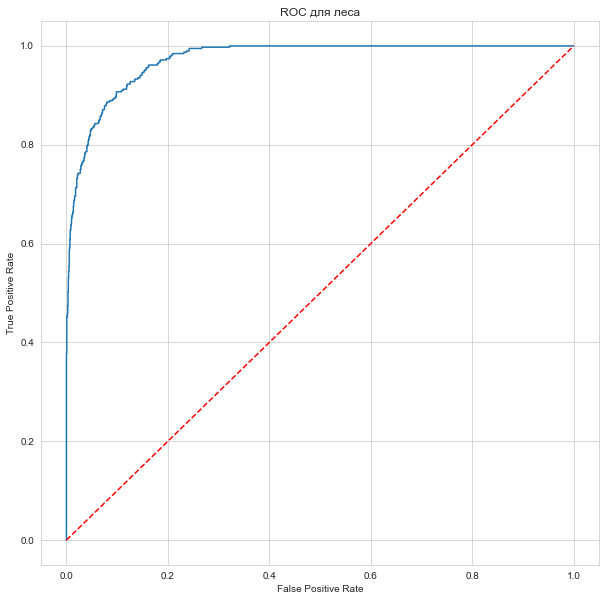

In [52]:
# параметры для построения кривых
fpr_forest, tpr_forest, thresholds_forest = roc_curve(target_test, proba_one)

# создание объекта figure
fig = plt.figure(figsize=(10, 10))

plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title('ROC для леса')

plt.plot(fpr_forest, tpr_forest)
plt.plot([0, 1], [0, 1], linestyle='--', color='r')

# ROC-кривая случайной модели (выглядит как прямая)

plt.show()

In [53]:
print('Random forest AUC-ROC:', round(roc_auc_score(target_test, proba_one), 2))

Random forest AUC-ROC: 0.97


## Общий вывод

В данной работе были рассмотрены методы борьбы с дисбалансом классов в ходе решения задачи для организации "Бета-Банк".
Бета-Банк предоставил датасет, с целевым признаком **"факт ухода клиента"**, соотношение классов в котором составило 4:1.

Для решения поставленной задачи были отобраны необходимые признаки, произведена кодировка категориальных данных и масштабирование признаков для корректной работы моделей. Оценена работа 3 типов моделей машинного обучения и различные алгоритмы для нивелирования влияния дисбаланса классов из библиотеки imbalanced learn.

Итогом работы стала готовая модель машинного обучения **"Случайный лес"**, которая хорошо показала себя на тествой выборке с метрикой **F1** = 0.81 (что соответствует условию задачи F1 > 0.59) и **AUC-ROC** = 0.97.